# StarCat

Flip Tanedo  
Science Hack Day: SF 2017  
  
**Goal**: User inputs an image (perhaps of a cat). This notebook takes the image and identifies a set of stars that form a constellation for that image. 

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import data
from skimage import filters
import skimage.io as io
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.color import *
from random import randint
import os

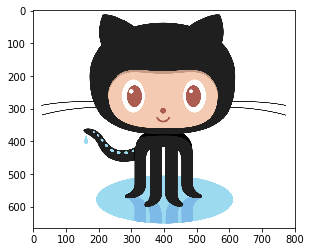

In [6]:
cat_image = io.imread('Octocat.jpg')
plt.imshow(cat_image)
plt.show()

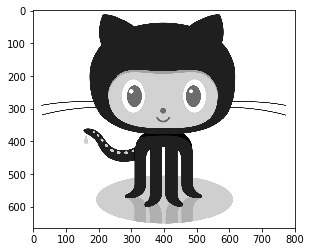

In [8]:
# We need to project down to black & white to use some
# of the scikit-image functions.
graycat = rgb2gray(cat_image)
plt.imshow(graycat, cmap='gray')
plt.show()

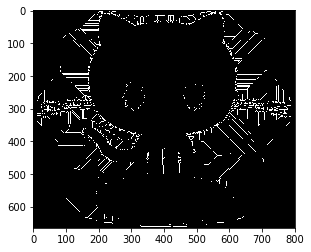

In [12]:
# This is not so helpful: we want something more sparse
skeleton = skeletonize(graycat)
plt.imshow(skeleton, cmap='gray')
plt.show()

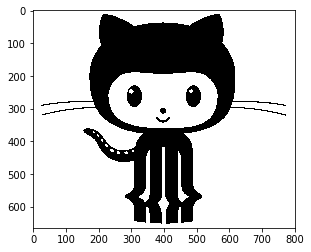

In [20]:
# http://www.scipy-lectures.org/packages/scikit-image/#histogram-based-method-otsu-thresholding
thresh = filters.threshold_mean(graycat)
binary = graycat > thresh
plt.imshow(binary, cmap=plt.cm.gray)
plt.show()

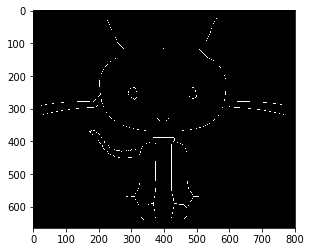

In [22]:
skeleton = skeletonize(invert(binary))
plt.imshow(skeleton, cmap='gray')
plt.show()

In [24]:
skeleton.shape

(665, 800)

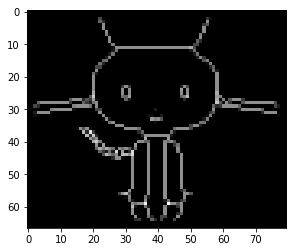

In [31]:
from skimage.measure import block_reduce
blockedcat = block_reduce(skeleton, block_size=(10,10))
plt.imshow(blockedcat, cmap='gray')
plt.show()

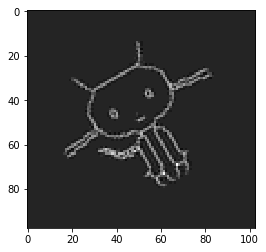

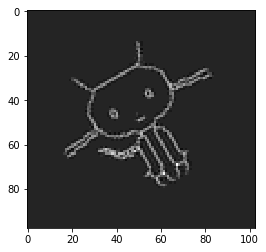

In [36]:
from scipy import ndimage as ndi
rotate=ndi.rotate(blockedcat, 30, mode='constant')
plt.imshow(rotate, cmap='gray')
plt.show()

# Do these commute?
rotate_skeleton=ndi.rotate(skeleton, 30, mode='constant')
blocked_rotation = block_reduce(rotate_skeleton, block_size=(10,10))
plt.imshow(rotate, cmap='gray')
plt.show()

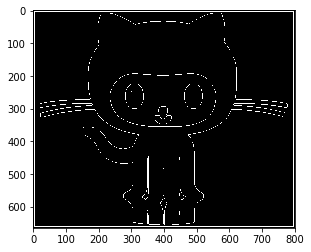

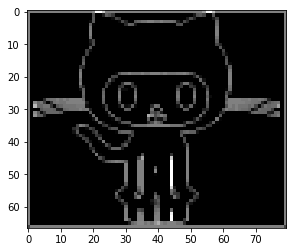

In [45]:
# Alternative: edge detect with Canny filter
# http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html
from scipy import ndimage as ndi
from skimage import feature

edge_cat = feature.canny(binary, sigma=1)
plt.imshow(edge_cat, cmap='gray')
plt.show()

blocked_edge_cat = block_reduce(edge_cat, block_size=(10,10))
plt.imshow(blocked_edge_cat, cmap='gray')
plt.show()

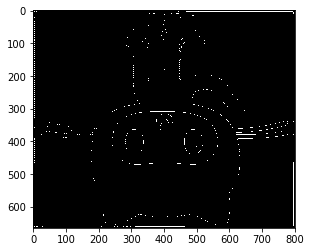

665
800


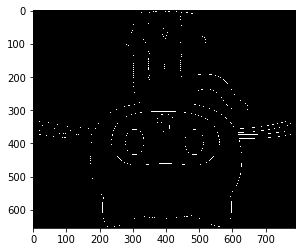

In [102]:
# Some cleaning: need to rotate ti upside down
# Need to remove the edges

rotate_edgecat=ndi.rotate(edge_cat, 180, mode='constant')
plt.imshow(rotate_edgecat, cmap='gray')
plt.show()

preHeight = np.shape(rotate_edgecat)[0]
preLength = np.shape(rotate_edgecat)[1]

print(preHeight)
print(preLength)

# This should be the "good" image
trim_edgecat = rotate_edgecat[5:(preHeight-5),5:(preLength-5)]
plt.imshow(trim_edgecat, cmap='gray')
plt.show()

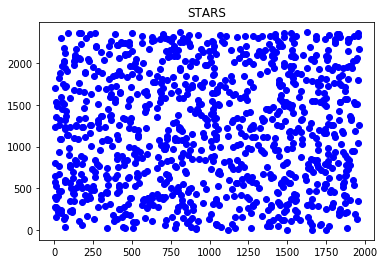

In [114]:
# Random Star Field
# Make it MULTIPLIER times larger than the image

MULTIPLIER = 3 
ImageHEIGHT = np.shape(trim_edgecat)[0]
StarHEIGHT = MULTIPLIER*ImageHEIGHT
ImageLENGTH = np.shape(trim_edgecat)[1]
StarLENGTH = MULTIPLIER*ImageLENGTH
NUMSTARS = 1000
starx = []
stary = []
for i in range(0,NUMSTARS):
    starx.append(randint(0,StarHEIGHT-1))
    stary.append(randint(0,StarLENGTH-1))
    
# Result: starx and stary are arrays of the star positions
    
plt.plot(np.array(starx), np.array(stary), 'bo')
plt.title("STARS")
plt.show()

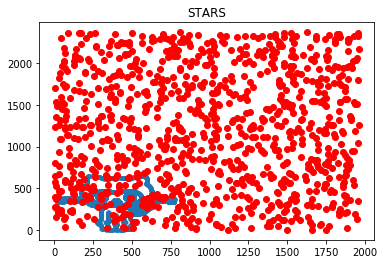

In [115]:
def one_dimensionalize(lineimage):
    """
    Stores points that are in the skeleton.
    Points are a list of pairs.
    i.e. [ [x0,y0], [x1,y1], ... ]
    """
    outline = []
    for ii in range(0,ImageLENGTH-1):
        for jj in range(0,ImageHEIGHT-1):
            if lineimage[jj,ii]:
                outline.append([ii,jj])
    return outline

def outline_x_and_y_lists(lineimage):
    """
    Same as one_dimensionalize,
    but directly gives a list of x-values
    and a list of y-values
    """
    xx = []
    yy = []
    for ii in range(0,ImageLENGTH-1):
        for jj in range(0,ImageHEIGHT-1):
            if lineimage[jj,ii]:
                xx.append(ii)
                yy.append(jj)
    return xx, yy


linexx, lineyy = outline_x_and_y_lists(trim_edgecat)

plt.title("STARS")
# plt.imshow(skeleton, cmap=plt.cm.gray)
# use this imshow to plot "right-size up"
plt.plot(np.array(linexx), np.array(lineyy), '.')
plt.plot(np.array(starx), np.array(stary), 'ro')
plt.show()

In [116]:
def pixel_distance(i,j,ii,jj):
    return np.sqrt((i-ii)**2 + (j-jj)**2)

def closest_skeleton(ii, jj, skelxx, skelyy):
    """
    Returns point from skelxx, skelyy that is
    closest to the given ii, jj point and the 
    Euclidean distance.
    """
    # Initialize
    closestx = skelxx[0]
    closesty = skelyy[0]
    closestd = np.sqrt(StarHEIGHT**2 + StarLENGTH**2)
    
    for a in range(0,np.size(skelxx)):
        if pixel_distance(ii,jj,skelxx[a],skelyy[a]) < closestd:
            closestx = skelxx[a]
            closesty = skelyy[a]
            closestd = pixel_distance(ii,jj,skelxx[a],skelyy[a])
    return closestx, closesty, closestd

closest_skeleton(0,0,linexx,lineyy)

(274, 86, 287.17938644686876)

In [117]:
def stars_and_closest_skeleton(starxx, staryy, skelxx, skelyy):
    """
    Gives unordered list of star positions, the skeleton position
    that is closest, and the distance between them.
    """
    allpoints=[]
    for a in range(0, np.size(starxx)):
        closex, closey, closed = closest_skeleton(starxx[a], staryy[a], skelxx, skelyy)
        allpoints.append([starxx[a],staryy[a],closex,closey,closed])
    
    return allpoints

unordered_points = stars_and_closest_skeleton(starx, stary, linexx, lineyy)

In [118]:
# Now find the best fit points
uop = np.array(unordered_points)
op = uop[uop[:,4].argsort()]
print(op[0:10])

[[ 176.          499.          176.          497.            2.        ]
 [ 414.          463.          414.          461.            2.        ]
 [ 337.          623.          336.          621.            2.23606798]
 [ 101.          347.          102.          349.            2.23606798]
 [ 540.          642.          538.          644.            2.82842712]
 [ 626.          389.          626.          386.            3.        ]
 [ 490.          177.          489.          180.            3.16227766]
 [ 348.          619.          345.          621.            3.60555128]
 [ 701.          368.          701.          372.            4.        ]
 [ 476.          314.          476.          310.            4.        ]]


[ 176.  414.  337.  101.  540.  626.  490.  348.  701.  476.  338.  441.
  607.  531.  565.  388.  476.  630.  672.  634.]
[ 499.  463.  623.  347.  642.  389.  177.  619.  368.  314.  460.   36.
  296.  637.  306.  619.  622.  418.  379.  297.]


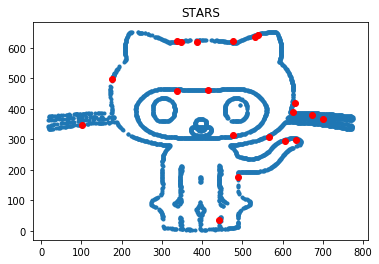

In [119]:
NUMSTARS = 20
beststarx=op[0:20][:,0]
beststary=op[0:20][:,1]

print(beststarx)
print(beststary)

plt.title("STARS")
# plt.imshow(trim_edgecat, cmap=plt.cm.gray)
plt.plot(np.array(linexx), np.array(lineyy), '.')
# plt.imshow(image)
# use this imshow to plot "right-size up"
# plt.plot(np.array(starx), np.array(stary), 'bo')
plt.plot(beststarx, beststary, 'ro')
plt.show()

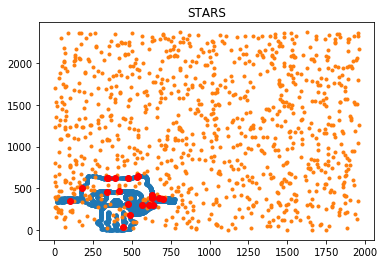

In [121]:
plt.title("STARS")
# plt.imshow(trim_edgecat, cmap=plt.cm.gray)
plt.plot(np.array(linexx), np.array(lineyy), '.')
# plt.imshow(image)
# use this imshow to plot "right-size up"
plt.plot(np.array(starx), np.array(stary), '.')
plt.plot(beststarx, beststary, 'ro')
plt.show()